/opt/conda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


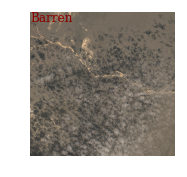

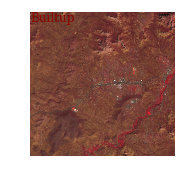

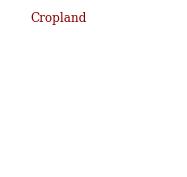

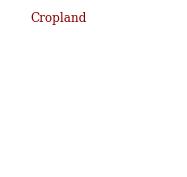

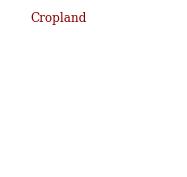

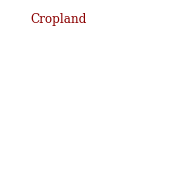

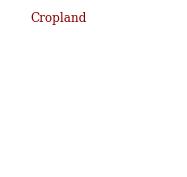

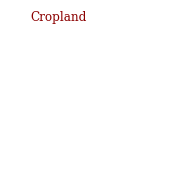

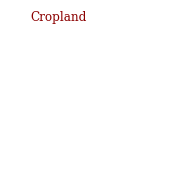

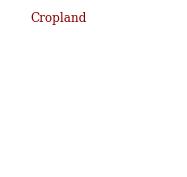

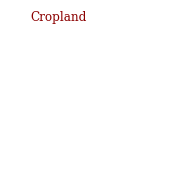

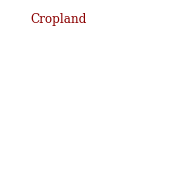

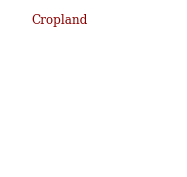

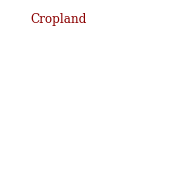

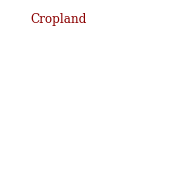

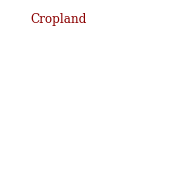

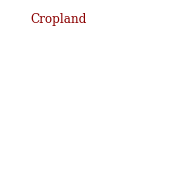

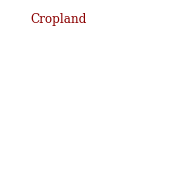

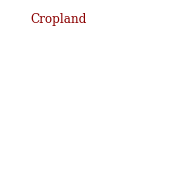

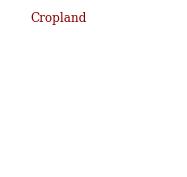

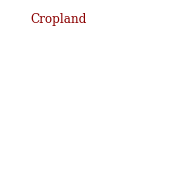

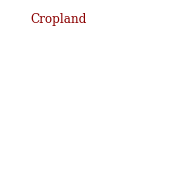

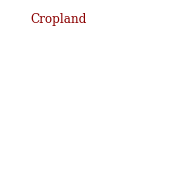

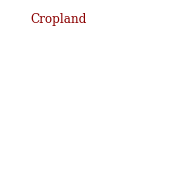

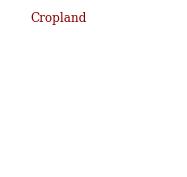

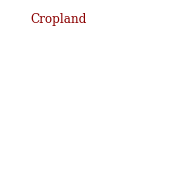

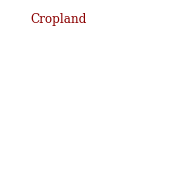

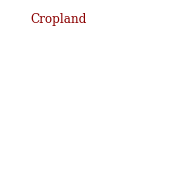

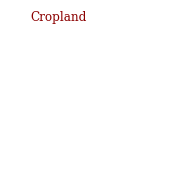

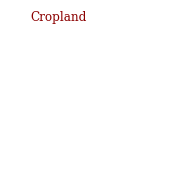

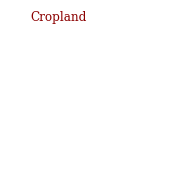

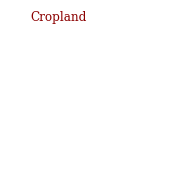

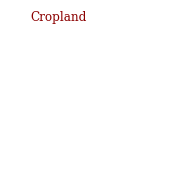

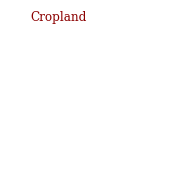

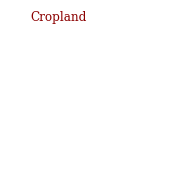

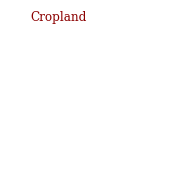

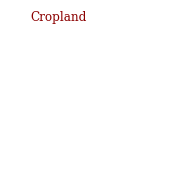

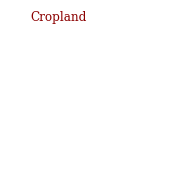

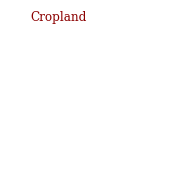

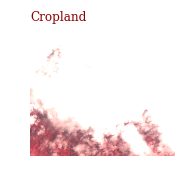

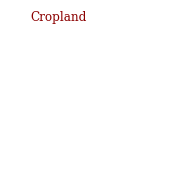

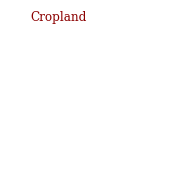

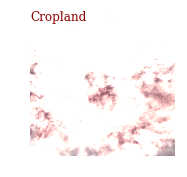

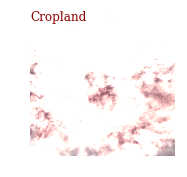

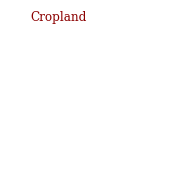

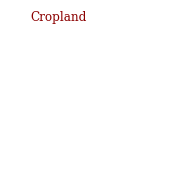

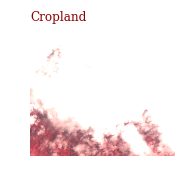

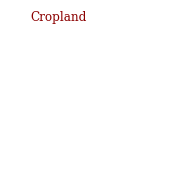

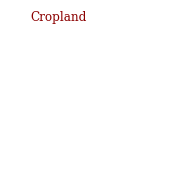

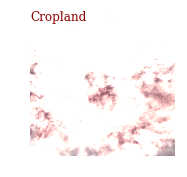

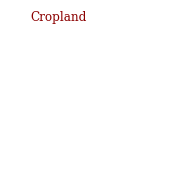

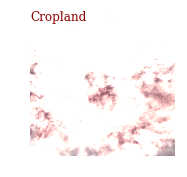

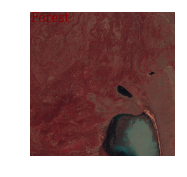

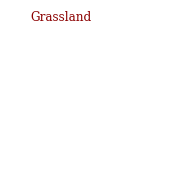

In [41]:
# create crop/non-crop samples
# import matplotlib;matplotlib.use('Agg')
%matplotlib inline
import ee; ee.Initialize()
from IPython.display import Image

import matplotlib.pyplot as plt
import urllib.request
from io import BytesIO

# type = 'Barren.Builtup.Cropland.Forest.Grassland.Shrubs.Water'.split()
sites = ee.FeatureCollection('ft:1C_gFvQmd3AGtB0Q0XgnKk5ESUARSH79FB9Un8sF2').filter(ee.Filter.neq('land_cover', 'Unknown'));
s1 = sites.filter(ee.Filter.eq('land_cover', 'Barren')).limit(1)
s1 = s1.merge(sites.filter(ee.Filter.eq('land_cover', 'Builtup')).limit(1))
s1 = s1.merge(sites.filter(ee.Filter.eq('land_cover', 'Cropland')).limit(50))
s1 = s1.merge(sites.filter(ee.Filter.eq('land_cover', 'Forest')).limit(1))
s1 = s1.merge(sites.filter(ee.Filter.eq('land_cover', 'Grassland')).limit(1))
s1 = s1.merge(sites.filter(ee.Filter.eq('land_cover', 'Shrubs')).limit(1)).toList(100)

landsat_mask = lambda img: img.updateMask(ee.Algorithms.Landsat.simpleCloudScore(img).select('cloud').lt(40)).float()
landsat = ee.ImageCollection('LANDSAT/LC8_L1T_TOA')
s2a, e2a, s2b, e2b, s2c, e2c = '2013-9-01','2013-11-30','2014-9-01','2014-11-30','2015-9-01','2015-11-30'
landsat2 = ee.ImageCollection('LANDSAT/LC8_L1T_TOA')\
.filter(ee.Filter.Or(ee.Filter.date(s2a,e2a), ee.Filter.date(s2b,e2b), ee.Filter.date(s2c,e2c)))\
.map(landsat_mask)

font = {'family': 'serif', 'color':  'darkred', 'weight': 'normal', 'size': 12}
for i in range(0, s1.size().getInfo()):
    point = ee.Feature(s1.get(i))
    label = point.get('land_cover').getInfo()
    pid = point.get('id').getInfo()
    oname = 'output/sample_%s_%s.png' % (label, pid)
#     print(oname)    
#     break
    region = point.geometry().buffer(5000).bounds().getInfo()['coordinates']
    data = BytesIO(urllib.request.urlopen(l8_image.getThumbUrl({'region':region, 'bands': 'B5,B4,B3', 'min':0, 'max': 0.5, 'format':'png'})).read())
    
    image = plt.imread(data)    
    fig = plt.figure()
    fig.set_size_inches(2, 2)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)    
    ax.imshow(image, aspect = 'auto')
    plt.text(2, 30, label, fontdict=font)
#     plt.text(2, 64, r'$\cos(2 \pi t) \exp(-t)$', fontdict=font)
#     plt.savefig(oname, dpi = 300)
#     break

In [ ]:
# get_ipython().magic('matplotlib inline')

import csv, itertools, requests
import urllib.request
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from io import BytesIO
import ee; ee.Initialize()
sentinel_img = ee.ImageCollection("COPERNICUS/S2").filterDate('2016-3-1', '2016-4-1').median()
font = {'family': 'serif',
        'color':  'yellow',
        'weight': 'normal',
        'size': 16,
        }
def everyrow(row):
    lat, lon = float(row["Latitude"]), float(row["Longitude"])
    print(lon, lat)
    oname = "%s-%s.png" % (row["id"], row["croptype"].replace('/', '-'))
    point = ee.Geometry.Point(lon, lat)
    region = point.buffer(1000).bounds().getInfo()['coordinates']
    url = sentinel_img.getThumbUrl({'bands': 'B8,B4,B3', 'region': region, 'min': 0,  'max': 4000, 'format':'png'})
    data = BytesIO(urllib.request.urlopen(url).read())

    image = plt.imread(data)  # crash on py3.x
    ax = plt.imshow(image)
    plt.axis('off')
    plt.text(256,207,'x', fontdict=font)
    plt.text(0,40, row["desc"] , fontdict=font)
    plt.savefig(oname)
    print(oname)

print(123)
# map(everyrow, csv.DictReader(open("TUN-sample-info.csv")))
for row in csv.DictReader(open("TUN-sample-info.csv")):
    #everyrow(row)
    lat, lon = float(row["Latitude"]), float(row["Longitude"])
    print(lon, lat)
    oname = "%s-%s.png" % (row["id"], row["croptype"].replace('/', '-'))
    point = ee.Geometry.Point(lon, lat)
    region = point.buffer(1000).bounds().getInfo()['coordinates']
    url = sentinel_img.getThumbUrl({'bands': 'B8,B4,B3', 'region': region, 'min': 0,  'max': 4000, 'format':'png'})
    data = BytesIO(urllib.request.urlopen(url).read())

    image = plt.imread(data)  # crash on py3.x
    #ax = plt.subplot()
    ax = plt.imshow(image)
    plt.axis('off')
    plt.text(256,207,'x', fontdict=font)
    plt.text(0,40, row["desc"] , fontdict=font)
    plt.savefig(oname)
    print(oname)
    plt.clf()
# list(map(everyrow, itertools.islice(csv.DictReader(open("TUN-sample-info.csv")),1)))

In [ ]:
#base.py
import numpy, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
import ee; ee.Initialize()
bandStack = lambda a, b: ee.Image(b).addBands(a)
get_value = lambda df, field: [feature['properties'][field] for feature in df]
def rename_bands(img):
    img = ee.Image(img)
    names = img.bandNames()
    prefix = ee.String(img.get("system:index")).cat("_")
    new_names = names.map(lambda b: prefix.cat(b))
    return img.select(names, new_names)
def load_dataset(oname, gee_func, update=False):
    if update:
        print('fetch from GEE....', end="")
        df = gee_func()        
        df.to_pickle(oname) # df.to_csv(oname)
        print('save to: ' + oname)
    else:
        print('load from local: ' + oname)
        df = pd.read_pickle(oname) # df.to_csv(oname+'.csv')
#         df = pd.read_csv(oname+'.csv', index_col=0)
    return df
# snippet to calculate time series
def getv(reduce, field, index): # get as field
    fc = reduce.getInfo()['features']
    value = [feature['properties'][field] for feature in fc]
    index = [feature['properties'][index] for feature in fc]    
    df = pd.DataFrame(get_value(fc, 'sum'), index=get_value(fc, 'country'))
    df = df.sort_index()
    return df
def gets(reduce, field, date=None): # get as timeseries
    fc = reduce.getInfo()['features']    
    columns = [df['properties']['name'] for df in fc]
    keys = sorted(fc[0]['properties'].keys())
    keys = [k for k in keys if not k.find(field) == -1]
    value = [[df['properties'][k] for df in fc] for k in keys]
    if date == None:
        if field == 'NDVI':
#             date = [k.split('005_')[1] for k in keys if not k.find(field) == -1]        
            date = [k.lstrip('MYD13Q1_005_').rstrip('_NDVI').replace('_','') for k in keys if not k.find(field) == -1]        
        else:
            date = [k.split('_')[0] for k in keys if not k.find(field) == -1]        
    else:
        pass
#     if field == 'NDVI':
#         print(date)
#     else:
    df = pd.DataFrame(value, columns=columns, index=pd.to_datetime(date, format="%Y%m%d"))
    return df
continent = ee.FeatureCollection('ft:1fM786Wbri6CqIz3JvyQ_vvMIBGbdUmTOGacZTnb-') # africa continent
aezs8 = ee.FeatureCollection('ft:19hZjN8dbwPbDHNdLVaoGLEtmIbxAtrn4yDr9QVgt') # africa AEZs
countries = ee.FeatureCollection('ft:1fGODObRcgWotUauiKV_2GlM7ZXX0sdZ5FLTJeALZ') # africa Countries
print('loaded: plt, pd, sns, getv, gets, continent, aezs8, countries')